## IEEE Victoris 1.0 Final Round
#### Image Classification Task
 the task is to develop a machine learning model that can classify the species that will appear in the images.
 images from camera traps located at different sites. There are seven types of critters captured in this set of images: birds, civets, duikers, hogs, leopards, other monkeys, and rodents. There are also images that contain no animals (blank).
 


## 1-reset the gpu for enough space for model

In [70]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

## 2- preprocessing images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
import seaborn as sns
import cv2
import random
from os import listdir

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import  LabelBinarizer

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

In [2]:
DIR = r'C:\Users\user\Desktop\AI_tasks\ieee_final\train_features\train_features'

X_array =[]
X_images =[]

for filename in listdir(DIR):
    filename = DIR + '\\' + filename
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (350,200))
    kernel = np.array([[0, -1, 0],
                      [-1, 5,-1],
                      [0, -1, 0]])
    sharpened = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    array = img_to_array(sharpened) 
    X_array.append(array)
    X_images.append(sharpened)       

X_images=np.array(X_images)
print(X_array[0].shape)
#print(X_images.shape)

(200, 350, 1)


In [60]:
 def show_image(image):
   plt.axis("off")
   plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
   plt.show()

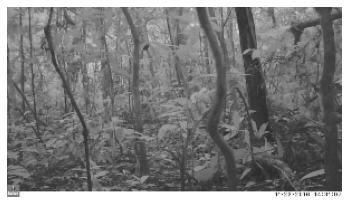

In [23]:
show_image(X_images[1])

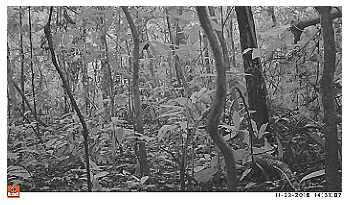

In [61]:
show_image(X_images[1])

In [3]:

labels=pd.read_csv(r'C:\Users\user\Desktop\AI_tasks\ieee_final\train_labels.csv',sep=',')
labels

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,ZJ000006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
12724,ZJ016483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12725,ZJ016484,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12726,ZJ016485,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12727,ZJ016486,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
y_label=labels[['antelope_duiker','bird','blank','civet_genet','hog','leopard','monkey_prosimian','rodent']]
y_label

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
12724,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12725,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12726,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12727,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
x_train, x_test, y_train, y_test = train_test_split(X_array, y_label, test_size=0.2, random_state = 0) 
print(f"Number of Training dataset: {len(x_train)}\nNumber of Testing dataset: {len(x_test)}")

Number of Training dataset: 10183
Number of Testing dataset: 2546


In [6]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 350,200,1)
x_test = x_test.reshape( -1, 350,200,1)

## 3- generate model
#### Ann Model

In [7]:
def load_model(): 
    model = Sequential([
        Flatten(input_shape=(350,200,1)),
        Dense(256, activation ='relu'),
        Dense(128, activation ='relu'),
        Dense(8, activation='softmax'),
    ])
    model.compile(
        optimizer= Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['acc'],
    )
    return model
    
    
early_stopping = callbacks.EarlyStopping(
        patience=10,
        min_delta=0,
        monitor='val_loss',
        restore_best_weights=True,
        verbose=0,
        mode='min', 
        baseline=None,
    )
plateau = callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=4, 
            verbose=0,
            mode='min')

ann_model = load_model()
history_ann = ann_model.fit(  x_train , y_train,
                validation_data = (x_test , y_test),
                epochs = 200,
                callbacks = [early_stopping , plateau]
              )

Epoch 1/200
319/319 [==============================] - 5s 11ms/step - loss: 3.3455 - acc: 0.3672 - val_loss: 1.9000 - val_acc: 0.4647 - lr: 5.0000e-04
Epoch 2/200
319/319 [==============================] - 3s 8ms/step - loss: 1.7597 - acc: 0.4935 - val_loss: 1.3739 - val_acc: 0.5393 - lr: 5.0000e-04
Epoch 3/200
319/319 [==============================] - 2s 8ms/step - loss: 1.2415 - acc: 0.5986 - val_loss: 1.0182 - val_acc: 0.6520 - lr: 5.0000e-04
Epoch 4/200
319/319 [==============================] - 3s 8ms/step - loss: 1.1349 - acc: 0.6273 - val_loss: 0.9924 - val_acc: 0.6540 - lr: 5.0000e-04
Epoch 5/200
319/319 [==============================] - 2s 8ms/step - loss: 1.0022 - acc: 0.6711 - val_loss: 1.3743 - val_acc: 0.6021 - lr: 5.0000e-04
Epoch 6/200
319/319 [==============================] - 3s 8ms/step - loss: 0.9325 - acc: 0.6966 - val_loss: 0.9888 - val_acc: 0.6528 - lr: 5.0000e-04
Epoch 7/200
319/319 [==============================] - 2s 8ms/step - loss: 0.9466 - acc: 0.6938 - v

## cNN Model 
higher train accuracy but overfitting 

In [8]:
def load_model():
    model = Sequential([
        Conv2D(8, (3, 3), padding="same",input_shape=(300,200,1), activation="relu"),
        MaxPooling2D(pool_size=(3, 3)),
        Flatten(),
        Dense(128, activation ='relu'),
        Dense(8, activation="softmax")    
    ])
    model.compile(
        Adam(learning_rate=0.0005),
        loss = 'categorical_crossentropy',
        metrics = ['acc']
    )
    return model

early_stopping = callbacks.EarlyStopping(
        patience=10,
        min_delta=0,
        monitor='val_loss',
        restore_best_weights=True,
        verbose=0,
        mode='min', 
        baseline=None,
    )
plateau = callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=4, 
            verbose=0,
            mode='min')
CNN_model_checkpoint = callbacks.ModelCheckpoint('CNN_best_model.h5', monitor='val_loss', mode='min', patience = 10 ,save_best_only=True)

nn_model = load_model()
history = nn_model.fit(  x_train , y_train,
                validation_data = (x_test , y_test),
                epochs = 100,
                callbacks = [early_stopping , plateau, CNN_model_checkpoint],
              )

Epoch 1/100
319/319 [==============================] - 7s 14ms/step - loss: 1.6076 - acc: 0.4005 - val_loss: 1.3366 - val_acc: 0.5008 - lr: 5.0000e-04
Epoch 2/100
319/319 [==============================] - 4s 12ms/step - loss: 1.1844 - acc: 0.5728 - val_loss: 1.0083 - val_acc: 0.6567 - lr: 5.0000e-04
Epoch 3/100
319/319 [==============================] - 4s 12ms/step - loss: 0.9817 - acc: 0.6609 - val_loss: 0.8864 - val_acc: 0.7035 - lr: 5.0000e-04
Epoch 4/100
319/319 [==============================] - 4s 12ms/step - loss: 0.8486 - acc: 0.7108 - val_loss: 0.8402 - val_acc: 0.7160 - lr: 5.0000e-04
Epoch 5/100
319/319 [==============================] - 4s 12ms/step - loss: 0.7404 - acc: 0.7502 - val_loss: 0.7388 - val_acc: 0.7443 - lr: 5.0000e-04
Epoch 6/100
319/319 [==============================] - 4s 12ms/step - loss: 0.6659 - acc: 0.7788 - val_loss: 0.7056 - val_acc: 0.7557 - lr: 5.0000e-04
Epoch 7/100
319/319 [==============================] - 4s 11ms/step - loss: 0.6013 - acc: 0.79

In [8]:
y_pred = ann_model.predict(x_test)
y_pred

80/80 [==============================] - 0s 3ms/step


array([[9.8803246e-01, 1.5281784e-04, 1.1516933e-02, ..., 1.0830754e-06,
        2.7079252e-04, 8.0370328e-06],
       [5.8320944e-07, 3.5919663e-07, 1.3101586e-05, ..., 9.9991572e-01,
        2.6147976e-08, 2.4782785e-05],
       [5.7268175e-05, 1.1506190e-08, 9.4516249e-04, ..., 1.7894386e-06,
        8.6145659e-09, 9.5878856e-04],
       ...,
       [2.6608514e-02, 1.2113626e-05, 3.5442930e-02, ..., 4.4364796e-04,
        8.1429687e-05, 2.2210167e-01],
       [8.2519278e-02, 4.5462206e-04, 3.9497994e-02, ..., 1.5585140e-04,
        8.7601155e-01, 6.0263998e-04],
       [2.0296299e-03, 1.8384179e-06, 5.3547062e-03, ..., 2.4837871e-05,
        1.4204174e-06, 3.1409855e-04]], dtype=float32)

In [9]:
y_predicted_labels = [np.argmax(i) for i in y_pred]
y_predicted_labels = np.array(y_predicted_labels)
y_predicted_labels

array([0, 5, 3, ..., 3, 6, 3], dtype=int64)

In [13]:
ann_model.evaluate(x_test, y_test)

80/80 [==============================] - 1s 6ms/step - loss: 0.4510 - acc: 0.8449


[0.4510382413864136, 0.8448546528816223]

In [11]:
y_test_arr=np.array(y_test)
y_test_array = [np.argmax(i) for i in y_test_arr]
y_test_array = np.array(y_test_array)
cm = tf.math.confusion_matrix(labels=y_test_array, predictions=y_predicted_labels)
cm



<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[294,   7,  61,   7,   1,   5,  24,  13],
       [  0, 242,  11,   0,   0,   2,   0,   1],
       [ 79,   9, 169,  12,   5,  12,  29,  16],
       [  1,   0,  10, 411,   0,   0,   0,   5],
       [  1,   0,   6,   0, 120,   6,   1,   0],
       [  0,   0,  13,   0,   7, 263,   1,   0],
       [ 13,   2,  16,   0,   0,   0, 385,   0],
       [  9,   3,   5,   2,   0,   0,   0, 267]])>

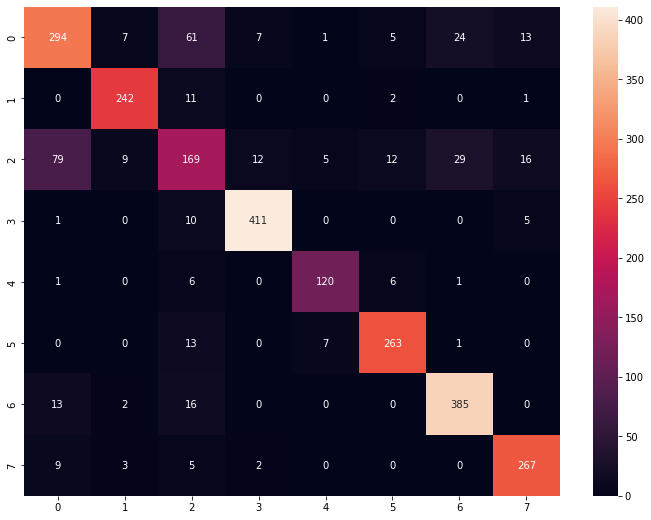

In [12]:
plt.figure(figsize=(12,9))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

## 4- searching the relation between site ,animals and size of images 

In [ ]:
sites=pd.read_csv(r'C:\Users\user\Desktop\AI_tasks\ieee_final\train_set.csv',sep=',')
sites

,id,filepath,site
0,ZJ000000,train_features/ZJ000000.jpg,S0120
1,ZJ000001,train_features/ZJ000001.jpg,S0069
2,ZJ000002,train_features/ZJ000002.jpg,S0009
3,ZJ000004,train_features/ZJ000004.jpg,S0036
4,ZJ000006,train_features/ZJ000006.jpg,S0060
...,...,...,...
12724,ZJ016483,train_features/ZJ016483.jpg,S0093
12725,ZJ016484,train_features/ZJ016484.jpg,S0043
12726,ZJ016485,train_features/ZJ016485.jpg,S0089
12727,ZJ016486,train_features/ZJ016486.jpg,S0095


In [ ]:
length=[]
width=[]
for image in X_images:
    length.append(image.shape[0])
    width.append(image.shape[1])
labels['length'] = np.array(length)
labels['width'] = np.array(width)
labels['site'] = sites['site']
labels

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,length,width,site,encode
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,540,960,S0120,1
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,540,960,S0069,6
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,360,640,S0009,1
3,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,335,640,S0036,5
4,ZJ000006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,540,960,S0060,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12724,ZJ016483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,540,960,S0093,2
12725,ZJ016484,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,360,640,S0043,5
12726,ZJ016485,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,360,640,S0089,3
12727,ZJ016486,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,540,960,S0095,1


In [ ]:
labels['site'].value_counts()

S0060    1132
S0009     664
S0063     557
S0036     456
S0043     444
         ... 
S0112       4
S0092       3
S0078       2
S0079       2
S0178       2
Name: site, Length: 111, dtype: int64

In [ ]:
labels.isnull().sum()

id                  0
antelope_duiker     0
bird                0
blank               0
civet_genet         0
hog                 0
leopard             0
monkey_prosimian    0
rodent              0
length              0
width               0
site                0
dtype: int64

In [ ]:
encode=[]
for ind in labels.index:
    if labels['antelope_duiker'][ind]== 1:
        code=0
    if labels['bird'][ind]== 1:
        code=1
    if labels['blank'][ind]== 1:
        code=2
    if labels['civet_genet'][ind]== 1:
        code=3
    if labels['hog'][ind]== 1:
        code=4
    if labels['leopard'][ind]== 1:
        code=5
    if labels['monkey_prosimian'][ind]== 1:
        code=6
    if labels['rodent'][ind]== 1:
        code=7       
    encode.append(code)
labels['encode'] = np.array(encode)
labels

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,length,width,site,encode
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,540,960,S0120,1
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,540,960,S0069,6
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,360,640,S0009,1
3,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,335,640,S0036,5
4,ZJ000006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,540,960,S0060,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12724,ZJ016483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,540,960,S0093,2
12725,ZJ016484,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,360,640,S0043,5
12726,ZJ016485,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,360,640,S0089,3
12727,ZJ016486,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,540,960,S0095,1


In [24]:
labels.to_csv(r'C:\Users\user\Desktop\AI_tasks\ieee_final\labels.csv',index=False)

In [16]:
labels [labels['site']=='S0060']['encode'].value_counts()

3    959
0     59
6     49
2     23
7     22
4     20
Name: encode, dtype: int64

In [17]:
labels [labels['site']=='S0178']['encode'].value_counts()

5    2
Name: encode, dtype: int64

In [18]:
labels['site'] = labels['site'].str.replace(r'S', '').astype(int)
labels

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,length,width,site,encode
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,540,960,120,1
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,540,960,69,6
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,360,640,9,1
3,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,335,640,36,5
4,ZJ000006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,540,960,60,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12724,ZJ016483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,540,960,93,2
12725,ZJ016484,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,360,640,43,5
12726,ZJ016485,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,360,640,89,3
12727,ZJ016486,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,540,960,95,1


In [37]:
labels[labels['site']=='S0036']['width'].value_counts()

640    456
Name: width, dtype: int64

In [28]:
x=labels['site'].value_counts()[:10].to_list()
y=labels['site'].value_counts().index[:10] 
y

Index(['S0060', 'S0009', 'S0063', 'S0036', 'S0043', 'S0059', 'S0120', 'S0062',
       'S0141', 'S0071'],
      dtype='object')

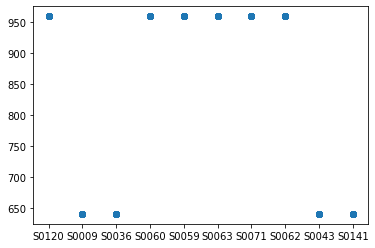

In [30]:
plt.scatter(labels[labels['site'].isin(y)]['site'],labels[labels['site'].isin(y)]['width'])

## 5- make prediction on test data and prepare it for submission  

In [14]:
DIR = r'C:\Users\user\Desktop\AI_tasks\ieee_final\test_features\test_features'

test_images = []
test_array =[]

for filename in listdir(DIR):
    filename = DIR + '\\' + filename
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (350,200))
    kernel = np.array([[0, -1, 0],
                      [-1, 5,-1],
                      [0, -1, 0]])
    sharpened = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    array = img_to_array(sharpened) 

    test_array.append(array)
           


In [15]:
tst=pd.read_csv(r'C:\Users\user\Desktop\AI_tasks\ieee_final\test_set.csv',sep=',')
tst

,id,filepath,site
0,ZJ000003,test_features/ZJ000003.jpg,S0008
1,ZJ000005,test_features/ZJ000005.jpg,S0019
2,ZJ000011,test_features/ZJ000011.jpg,S0014
3,ZJ000012,test_features/ZJ000012.jpg,S0080
4,ZJ000017,test_features/ZJ000017.jpg,S0080
...,...,...,...
3754,ZJ016470,test_features/ZJ016470.jpg,S0002
3755,ZJ016475,test_features/ZJ016475.jpg,S0038
3756,ZJ016476,test_features/ZJ016476.jpg,S0184
3757,ZJ016477,test_features/ZJ016477.jpg,S0045


In [16]:
test= np.array(test_array, dtype=np.float16) / 225.0
test = test.reshape( -1, 350,200,1)

In [17]:
test[0]

array([[[0.4934],
        [0.511 ],
        [0.28  ],
        ...,
        [0.511 ],
        [0.2622],
        [0.3823]],

       [[0.1823],
        [0.547 ],
        [0.849 ],
        ...,
        [0.3333],
        [0.533 ],
        [0.6357]],

       [[0.5957],
        [0.4934],
        [0.44  ],
        ...,
        [0.4   ],
        [0.4443],
        [0.5913]],

       ...,

       [[1.134 ],
        [1.134 ],
        [1.134 ],
        ...,
        [1.134 ],
        [1.134 ],
        [1.129 ]],

       [[1.129 ],
        [1.129 ],
        [1.134 ],
        ...,
        [1.134 ],
        [1.134 ],
        [1.134 ]],

       [[1.134 ],
        [1.134 ],
        [1.134 ],
        ...,
        [1.134 ],
        [1.022 ],
        [1.134 ]]], dtype=float16)

In [18]:
pred = ann_model.predict(test)
pred

118/118 [==============================] - 0s 3ms/step


array([[4.89748329e-01, 5.89924632e-04, 4.03200954e-01, ...,
        2.53848359e-03, 5.66765619e-03, 2.03444753e-02],
       [1.51996791e-01, 4.49542586e-06, 6.43475115e-01, ...,
        9.52362269e-03, 1.00620045e-05, 7.68541768e-02],
       [2.49828652e-01, 5.59350010e-03, 9.64522511e-02, ...,
        1.07526584e-02, 5.48177719e-01, 7.29332641e-02],
       ...,
       [2.05023676e-01, 2.62706653e-05, 4.21379238e-01, ...,
        1.60473306e-02, 1.11480782e-04, 2.40271837e-01],
       [2.27912273e-02, 4.37370181e-05, 1.05820142e-01, ...,
        1.23984581e-02, 2.61720415e-05, 1.53958604e-01],
       [1.85770355e-02, 1.22629926e-01, 5.26920334e-02, ...,
        3.99646237e-02, 7.53651440e-01, 7.76281254e-03]], dtype=float32)

In [19]:
sumbit=tst[['id']]
sumbit

,id
0,ZJ000003
1,ZJ000005
2,ZJ000011
3,ZJ000012
4,ZJ000017
...,...
3754,ZJ016470
3755,ZJ016475
3756,ZJ016476
3757,ZJ016477


In [20]:
df = pd.DataFrame(pred)

In [21]:
df

,0,1,2,3,4,5,6,7
0,0.489748,0.000590,0.403201,0.017013,6.089745e-02,2.538484e-03,0.005668,0.020344
1,0.151997,0.000004,0.643475,0.079892,3.824322e-02,9.523623e-03,0.000010,0.076854
2,0.249829,0.005594,0.096452,0.010495,5.766494e-03,1.075266e-02,0.548178,0.072933
3,0.278362,0.038198,0.414019,0.000011,4.767084e-03,7.593829e-03,0.252538,0.004511
4,0.188279,0.000040,0.790396,0.000030,5.868712e-08,3.704421e-07,0.021252,0.000003
...,...,...,...,...,...,...,...,...
3754,0.157158,0.103205,0.553689,0.000124,2.332482e-02,5.822019e-02,0.101517,0.002762
3755,0.090227,0.397221,0.125948,0.000054,3.006950e-01,2.448378e-02,0.021131,0.040240
3756,0.205024,0.000026,0.421379,0.053062,6.407829e-02,1.604733e-02,0.000111,0.240272
3757,0.022791,0.000044,0.105820,0.704778,1.839765e-04,1.239846e-02,0.000026,0.153959


In [22]:
sumbit['antelope_duiker']=df[0]
sumbit['bird']=df[1]
sumbit['blank']=df[2]
sumbit['civet_genet']=df[3]
sumbit['hog']=df[4]
sumbit['leopard']=df[5]
sumbit['monkey_prosimian']=df[6]
sumbit['rodent']=df[7]
sumbit

C:\Users\user\AppData\Local\Temp\ipykernel_21556\271816173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sumbit['antelope_duiker']=df[0]


,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000003,0.489748,0.000590,0.403201,0.017013,6.089745e-02,2.538484e-03,0.005668,0.020344
1,ZJ000005,0.151997,0.000004,0.643475,0.079892,3.824322e-02,9.523623e-03,0.000010,0.076854
2,ZJ000011,0.249829,0.005594,0.096452,0.010495,5.766494e-03,1.075266e-02,0.548178,0.072933
3,ZJ000012,0.278362,0.038198,0.414019,0.000011,4.767084e-03,7.593829e-03,0.252538,0.004511
4,ZJ000017,0.188279,0.000040,0.790396,0.000030,5.868712e-08,3.704421e-07,0.021252,0.000003
...,...,...,...,...,...,...,...,...,...
3754,ZJ016470,0.157158,0.103205,0.553689,0.000124,2.332482e-02,5.822019e-02,0.101517,0.002762
3755,ZJ016475,0.090227,0.397221,0.125948,0.000054,3.006950e-01,2.448378e-02,0.021131,0.040240
3756,ZJ016476,0.205024,0.000026,0.421379,0.053062,6.407829e-02,1.604733e-02,0.000111,0.240272
3757,ZJ016477,0.022791,0.000044,0.105820,0.704778,1.839765e-04,1.239846e-02,0.000026,0.153959


In [23]:
sumbit.dtypes

id                   object
antelope_duiker     float32
bird                float32
blank               float32
civet_genet         float32
hog                 float32
leopard             float32
monkey_prosimian    float32
rodent              float32
dtype: object

In [24]:
sumbit.to_csv(r'C:\Users\user\Desktop\AI_tasks\ieee_final\ieee_final8.csv',index=False)